In [1]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np
from itertools import zip_longest

import pysal

from bs4 import BeautifulSoup
import re
import requests
import unidecode
import string
import datetime
import time
from IPython.display import clear_output
import urllib3
import certifi

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())

In [3]:
ag = gpd.read_file('Allegheny_County_Municipal_Boundaries')

In [4]:
ag_center = ag.geometry.centroid

In [5]:
ag = ag.drop(['OBJECTID','COG', 'SCHOOLD', 'CONGDIST', 'FIPS', 'REGION', 'ACRES', 'SQMI', 'MUNICODE', 'CNTL_ID', 'CNTYCOUNCI','EOC', 'ASSESSORTE', 'VALUATIONA', 'YEARCONVER', 'GlobalID'], axis=1)

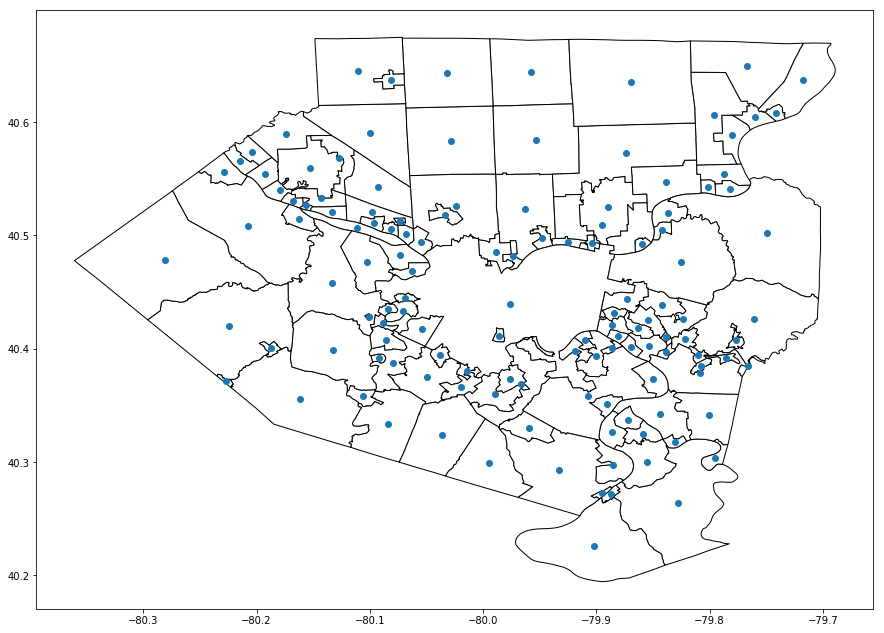

In [6]:
base = ag.plot(figsize=(15,15), color='white', edgecolor='black')
ag_center.plot(ax=base)

In [114]:
ag[ag['LABEL'].str.contains('pittsburgh')].sort_values('LABEL')

NAME     TYPE                    LABEL  \
56   EAST PITTSBURGH  borough  east pittsburgh borough   
127       PITTSBURGH     city               pittsburgh   

                                              geometry  
56   POLYGON ((-79.8336939635457 40.4005454952576, ...  
127  POLYGON ((-79.9072100559346 40.3615741498475, ...

In [46]:
ag['TYPE'] = ag['TYPE'].map(lambda x: x.lower() if x in ['CITY', 'BOROUGH', 'TOWNSHIP'] else 'municipality')

In [47]:
ag['TYPE'].value_counts()

borough         82
township        40
municipality     4
city             4
Name: TYPE, dtype: int64

In [67]:
ag['LABEL'] = ag['LABEL'].map(lambda x: x.lower())

In [68]:
ag.head()

NAME      TYPE                      LABEL  \
0           CHESWICK   borough           cheswick borough   
1          EDGEWORTH   borough          edgeworth borough   
2          SEWICKLEY   borough          sewickley borough   
3  SEWICKLEY HEIGHTS   borough  sewickley heights borough   
4             HARMAR  township            harmar township   

                                            geometry  
0  POLYGON ((-79.79505534034141 40.5453860140899,...  
1  POLYGON ((-80.18101605697569 40.5646216093466,...  
2  POLYGON ((-80.1729837236676 40.5507583281184, ...  
3  POLYGON ((-80.17154496192239 40.5412766058262,...  
4  POLYGON ((-79.80756925277041 40.537292425016, ...

In [49]:
def juris_cleaner(j):
    j2 = j.lower()
    replacers = {'city of':'', '(westmoreland county)':'', 'mt.':'mount', 'bureau of':'',
                 'greentree':'green tree', 'ohara':'o\'hara', 'alleppo':'aleppo'}
    for k, v in replacers.items():
        j2 = j2.replace(k, v).strip()
    j3 = [w for w in j2.split() if w not in ['borough', 'township', 'municipality', 'city']]
    return ' '.join(j3)

In [178]:
# import pop data
pop = pd.read_csv('PEP_2017_PEPANNRES/PEP_2017_PEPANNRES_with_ann.csv')

# rename
pop = pop[['GEO.display-label', 'respop72017']].rename(columns={'GEO.display-label':'name', 'respop72017':'pop 2017'})

# filter by ag county
pop = pop[pop['name'].str.contains('Allegheny County')]

# clean 'name' column
pop['name'] = pop['name'].map(lambda x: x.replace(', Allegheny County, Pennsylvania', '').lower())
pop['name'] = pop['name'].map(lambda x: x.replace(' city', ''))

# spot editing
pop['name'] = pop['name'].map(lambda x: x.replace('o\'hara', 'o hara'))
pop['name'] = pop['name'].map(lambda x: x.replace('lebanon township', 'lebanon'))
pop['name'] = pop['name'].map(lambda x: x.replace('clair township', 'clair municipality'))
pop['name'] = pop['name'].map(lambda x: x.replace('hills township', 'hills municipality'))

# create log column
pop['log 2017'] = pop['pop 2017'].map(np.log)

In [198]:
ag_pop = pd.merge(ag, pop, how='left', left_on='LABEL', right_on='name').drop('name', axis=1)

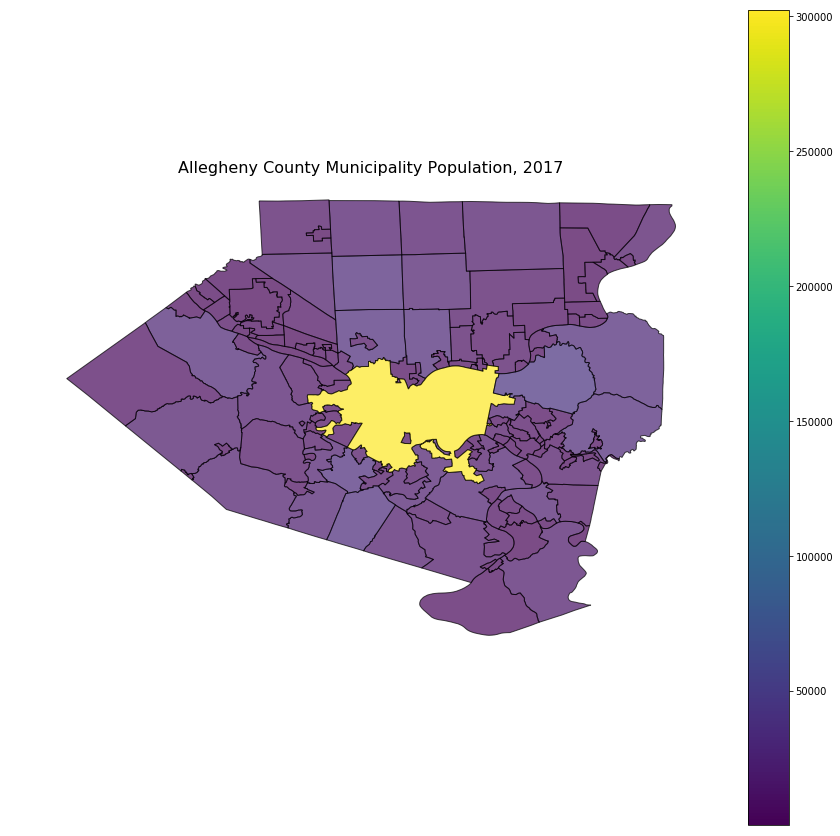

In [184]:
ag_pop.plot(figsize=(15,15), edgecolor='black', column='pop 2017', alpha=0.7,
              legend=True, legend_kwds={'loc': 4})
plt.title('Allegheny County Municipality Population, 2017', size=16)
plt.axis('off');

In [243]:
# import data
pd_manual = pd.read_csv('ag_police_manually.csv')

# subset columns
pd_manual = pd_manual.iloc[:,0:4]
pd_manual.rename(columns={
    'total or undetermined (including sgt/chief)':'officers'}, inplace=True)

# combine name columns
pd_manual['full name'] = pd_manual['name'] + ' ' + pd_manual['muni type']

# spot fixes
pd_manual['full name'] = pd_manual['full name'].map(lambda x: x.replace('o\'hara', 'o hara'))
pd_manual['full name'] = pd_manual['full name'].map(lambda x: x.replace('lebanon township', 'lebanon'))
pd_manual['full name'] = pd_manual['full name'].map(lambda x: x.replace(' city', ''))

# adjust 'officers' column
pd_manual['officers'] = pd_manual['officers'].map(lambda x: np.NaN if x in ['NA','no data'] else x)
pd_manual['officers'] = pd.to_numeric(pd_manual['officers'])

In [244]:
pd_manual.head()

name muni type                 agency  officers           full name
0   aspinwall   borough         Aspinwall P.D.      11.0   aspinwall borough
1      avalon   borough            Avalon P.D.       9.0      avalon borough
2     baldwin   borough   Baldwin Borough P.D.      30.0     baldwin borough
3     baldwin  township  Baldwin Township P.D.       6.0    baldwin township
4  bell acres   borough        Bell Acres P.D.       9.0  bell acres borough

In [245]:
ag_pop.head()

NAME      TYPE                      LABEL  \
0           CHESWICK   borough           cheswick borough   
1          EDGEWORTH   borough          edgeworth borough   
2          SEWICKLEY   borough          sewickley borough   
3  SEWICKLEY HEIGHTS   borough  sewickley heights borough   
4             HARMAR  township            harmar township   

                                            geometry  pop 2017  log 2017  
0  POLYGON ((-79.79505534034141 40.5453860140899,...      1703  7.440147  
1  POLYGON ((-80.18101605697569 40.5646216093466,...      1656  7.412160  
2  POLYGON ((-80.1729837236676 40.5507583281184, ...      3839  8.252967  
3  POLYGON ((-80.17154496192239 40.5412766058262,...       811  6.698268  
4  POLYGON ((-79.80756925277041 40.537292425016, ...      3030  8.016318

In [246]:
ag_pop_pd = pd.merge(
    ag_pop, pd_manual, how='left', left_on='LABEL', right_on='full name').drop(
    ['NAME','TYPE','full name', 'name','muni type'], axis=1)

In [247]:
ag_pop_pd.head()

LABEL  \
0           cheswick borough   
1          edgeworth borough   
2          sewickley borough   
3  sewickley heights borough   
4            harmar township   

                                            geometry  pop 2017  log 2017  \
0  POLYGON ((-79.79505534034141 40.5453860140899,...      1703  7.440147   
1  POLYGON ((-80.18101605697569 40.5646216093466,...      1656  7.412160   
2  POLYGON ((-80.1729837236676 40.5507583281184, ...      3839  8.252967   
3  POLYGON ((-80.17154496192239 40.5412766058262,...       811  6.698268   
4  POLYGON ((-79.80756925277041 40.537292425016, ...      3030  8.016318   

                   agency  officers  
0           Cheswick P.D.       9.0  
1          Edgeworth P.D.      10.0  
2          Sewickley P.D.      20.0  
3  Sewickley Heights P.D.       7.0  
4    Harmar Township P.D.      12.0

In [268]:
agencies = ag_pop_pd[['agency','officers','pop 2017']].groupby('agency').sum().reset_index()

In [269]:
agencies.head()

agency  officers  pop 2017
0         Aspinwall P.D.      11.0      2732
1            Avalon P.D.       9.0      4586
2   Baldwin Borough P.D.      30.0     19610
3  Baldwin Township P.D.       6.0      1939
4        Bell Acres P.D.       9.0      1388

In [270]:
ag_count = ag_pop_pd[['agency','LABEL']].groupby('agency').count().reset_index().rename(columns={'LABEL':'jurisdictions'})

In [271]:
agencies = pd.merge(agencies, ag_count, on='agency')

In [272]:
agencies.head()

agency  officers  pop 2017  jurisdictions
0         Aspinwall P.D.      11.0      2732              1
1            Avalon P.D.       9.0      4586              1
2   Baldwin Borough P.D.      30.0     19610              1
3  Baldwin Township P.D.       6.0      1939              1
4        Bell Acres P.D.       9.0      1388              1

In [273]:
agencies = pd.merge(ag_pop_pd[['LABEL','geometry','agency']], agencies, how='outer', on='agency')

In [274]:
agencies.head()

LABEL  \
0           cheswick borough   
1          edgeworth borough   
2          sewickley borough   
3       glen osborne borough   
4  sewickley heights borough   

                                            geometry                  agency  \
0  POLYGON ((-79.79505534034141 40.5453860140899,...           Cheswick P.D.   
1  POLYGON ((-80.18101605697569 40.5646216093466,...          Edgeworth P.D.   
2  POLYGON ((-80.1729837236676 40.5507583281184, ...          Sewickley P.D.   
3  POLYGON ((-80.16027814768729 40.5255756902887,...          Sewickley P.D.   
4  POLYGON ((-80.17154496192239 40.5412766058262,...  Sewickley Heights P.D.   

   officers  pop 2017  jurisdictions  
0       9.0      1703              1  
1      10.0      1656              1  
2      40.0      4381              2  
3      40.0      4381              2  
4       7.0       811              1

In [347]:
agencies[agencies['jurisdictions'] > 1].dropna()

LABEL  \
2            sewickley borough   
3         glen osborne borough   
11     sewickley hills borough   
12               ohio township   
13            emsworth borough   
14            neville township   
15            ben avon borough   
16    ben avon heights borough   
17             aleppo township   
18            kilbuck township   
19           richland township   
20               pine township   
21           marshall township   
22      bradford woods borough   
52   pennsbury village borough   
53            carnegie borough   
65          wilmerding borough   
66   north versailles township   
67                wall borough   
68     east mckeesport borough   
78           elizabeth borough   
79      west elizabeth borough   
101          thornburg borough   
102            crafton borough   
115  south versailles township   
116          white oak borough   

                                              geometry  \
2    POLYGON ((-80.1729837236676 40.5507583281184, ...   
3    POLYGON ((-80.16027814768729 40.5255756902887,...   
11   POLYGON ((-80.11391083883321 40.5754688729187,...   
12   POLYGON ((-80.06401851255779 40.5422311112204,...   
13   POLYGON ((-80.08769044379861 40.5107440715966,...   
14   POLYGON ((-80.12029234700771 40.5131480116036,...   
15   POLYGON ((-80.0753413896951 40.508835024251, -...   
16   POLYGON ((-80.069518873257 40.5090008625284, -...   
17   POLYGON ((-80.1339614890952 40.5402018457929, ...   
18   POLYGON ((-80.1215600946054 40.5362648084359, ...   
19   POLYGON ((-79.9241799077394 40.6730530761047, ...   
20   POLYGON ((-79.9941739776751 40.6735797612277, ...   
21   POLYGON ((-80.1485008062522 40.6737766864665, ...   
22   POLYGON ((-80.0795766795873 40.6423135208804, ...   
52   POLYGON ((-80.1045258448307 40.4289797649603, ...   
53   POLYGON ((-80.079476491458 40.4148284260931, -...   
65   POLYGON ((-79.81499639162639 40.4011930097901,...   
66   POLYGON ((-79.8334836017325 40.3617757664708, ...   
67   POLYGON ((-79.80259798397751 40.3914270139733,...   
68   POLYGON ((-79.80275557211731 40.3847994662838,...   
78   POLYGON ((-79.8842357045127 40.2689417290848, ...   
79   POLYGON ((-79.88629581637591 40.2769244435173,...   
101  POLYGON ((-80.0834001810455 40.4397717656825, ...   
102  POLYGON ((-80.0740694889184 40.4403439998151, ...   
115  POLYGON ((-79.8071966381644 40.2995088264039, ...   
116  POLYGON ((-79.8163124030518 40.3241690013236, ...   

                     agency  officers  pop 2017  jurisdictions  
2            Sewickley P.D.      40.0      4381              2  
3            Sewickley P.D.      40.0      4381              2  
11       Ohio Township P.D.     272.0     15459              8  
12       Ohio Township P.D.     272.0     15459              8  
13       Ohio Township P.D.     272.0     15459              8  
14       Ohio Township P.D.     272.0     15459              8  
15       Ohio Township P.D.     272.0     15459              8  
16       Ohio Township P.D.     272.0     15459              8  
17       Ohio Township P.D.     272.0     15459              8  
18       Ohio Township P.D.     272.0     15459              8  
19   Northern Regional P.D.      60.0     34800              4  
20   Northern Regional P.D.      60.0     34800              4  
21   Northern Regional P.D.      60.0     34800              4  
22   Northern Regional P.D.      60.0     34800              4  
52            Carnegie P.D.      26.0      8559              2  
53            Carnegie P.D.      26.0      8559              2  
65    North Versailles P.D.      54.0     12161              2  
66    North Versailles P.D.      54.0     12161              2  
67     East McKeesport P.D.      20.0      2646              2  
68     East McKeesport P.D.      20.0      2646              2  
78   Elizabeth Borough P.D.      16.0      1984              2  
79   Elizabeth Borough P.D.      16.0      1984              2  
101            Crafton P.D.      18.0      6

In [342]:
# dissolve PD maps
a_dissolve = agencies[agencies['jurisdictions'] > 1].dropna().dissolve(by='agency').reset_index().drop('LABEL', axis=1)

In [366]:
# add dissolved maps back to other data
ag_pd_dissolve = pd.concat([agencies[agencies['jurisdictions'] == 1].drop(['LABEL'], axis=1), a_dissolve]).dropna().drop('jurisdictions', axis=1)

In [373]:
ag_pd_dissolve['ppl per officer'] = ag_pd_dissolve.apply(lambda x: x['pop 2017']/x['officers'], axis=1)

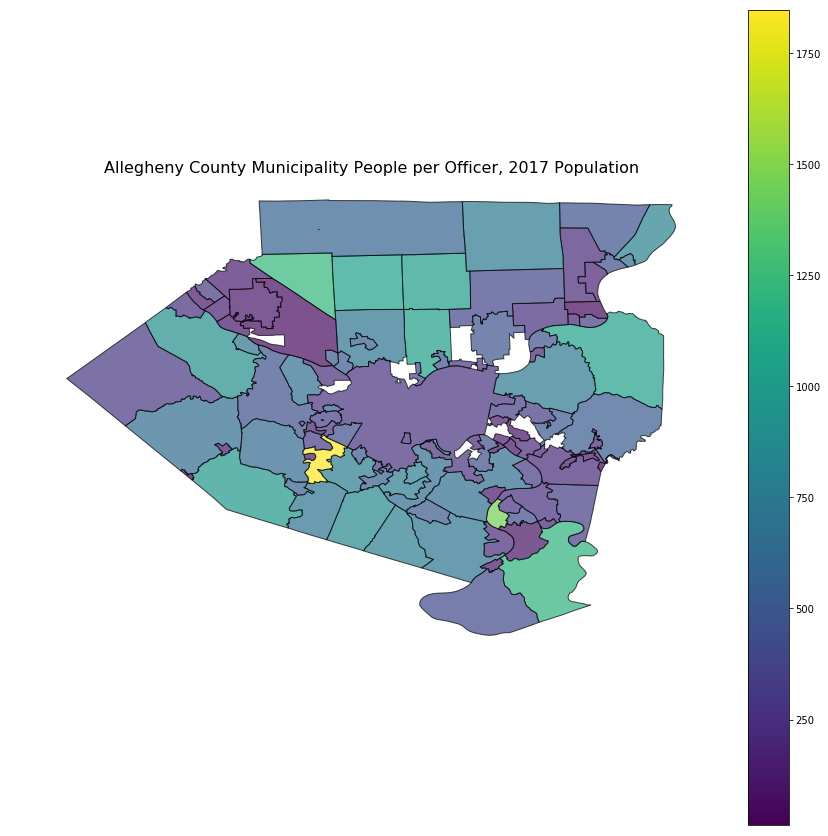

In [374]:
ag_pd_dissolve.plot(figsize=(15,15), edgecolor='black', column='ppl per officer', alpha=0.7,
              legend=True, legend_kwds={'loc': 4})
plt.title('Allegheny County Municipality People per Officer, 2017 Population', size=16)
plt.axis('off');

In [422]:
ag_pd_dissolve['log pop 2017'] = ag_pd_dissolve['pop 2017'].map(lambda x: np.log(x))

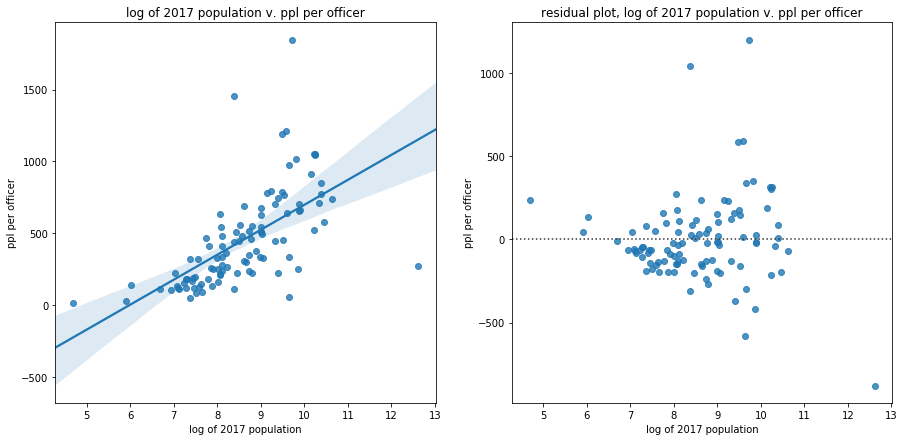

In [424]:
data = ag_pd_dissolve

fig = plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.title(s='log of 2017 population v. ppl per officer')
sns.regplot(data=data, x='log pop 2017', y='ppl per officer')
plt.xlabel(('log of 2017 population'))

plt.subplot(1,2,2)
plt.title(s='residual plot, log of 2017 population v. ppl per officer')
sns.residplot(data=data, x='log pop 2017', y='ppl per officer')
plt.xlabel(('log of 2017 population'));

In [399]:
import statsmodels.api as sm

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [425]:
# assign variables for linear model
data = ag_pd_dissolve
y = data['ppl per officer']
X = data['log pop 2017']

# model data and calculate residuals
model = sm.OLS(y,X)
results = model.fit()
y_hat = results.predict()
resid = y - y_hat

ag_pd_dissolve['residual'] = resid

In [426]:
ag_pd_dissolve

agency  \
0               Cheswick P.D.   
1              Edgeworth P.D.   
4      Sewickley Heights P.D.   
5        Harmar Township P.D.   
6             Fox Chapel P.D.   
7          Franklin Park P.D.   
8             Bell Acres P.D.   
9          Leet Township P.D.   
10              Leetsdale P.D   
23            McCandless P.D.   
26       Frazer Township P.D.   
27         Fawn Township P.D.   
28     Harrison Township P.D.   
29              Tarentum P.D.   
30                Avalon P.D.   
31              Millvale P.D.   
33       Shaler Township P.D.   
34             East Deer P.D.   
35           Wilkinsburg P.D.   
36                  Plum P.D.   
37        Braddock Hills P.D.   
38                Rankin P.D.   
40              Edgewood P.D.   
41             West View P.D.   
42             Churchill P.D.   
43           Monroeville P.D.   
46         Ross Township P.D.   
47          Brackenridge P.D.   
48   Springdale Township P.D.   
49    Heidelberg Borough P.D.   
..                        ...   
106        Moon Township P.D.   
107           Coraopolis P.D.   
108    Robinson Township P.D.   
109              Oakdale P.D.   
110             McDonald P.D.   
111        South Fayette P.D.   
112        North Fayette P.D.   
113     Findlay Township P.D.   
114     Forward Township P.D.   
117              Collier P.D.   
118              Hampton P.D.   
119             Pitcairn P.D.   
120     Indiana Township P.D.   
122            Aspinwall P.D.   
123            West Deer P.D.   
124      Jefferson Hills P.D.   
125             Bellevue P.D.   
126          Bethel Park P.D.   
127             Trafford P.D.   
128           Pittsburgh P.D.   
129           Penn Hills P.D.   
0               Carnegie P.D.   
1                Crafton P.D.   
2        East McKeesport P.D.   
3      Elizabeth Borough P.D.   
4       North Versailles P.D.   
5      Northern Regional P.D.   
6          Ohio Township P.D.   
7              Sewickley P.D.   
8              White Oak P.D.   

                                              geometry  officers  pop 2017  \
0    POLYGON ((-79.79505534034141 40.5453860140899,...       9.0      1703   
1    POLYGON ((-80.18101605697569 40.5646216093466,...      10.0      1656   
4    POLYGON ((-80.17154496192239 40.5412766058262,...       7.0       811   
5    POLYGON ((-79.80756925277041 40.537292425016, ...      12.0      3030   
6    POLYGON ((-79.8745868410042 40.5521014638257, ...      11.0      5309   
7    POLYGON ((-80.06830321776221 40.6163162161401,...      12.0     14552   
8    POLYGON ((-80.18651402502491 40.5689106363252,...       9.0      1388   
9    POLYGON ((-80.18651402502491 40.5689106363252,...       5.0      1591   
10   POLYGON ((-80.2191408777397 40.5793524120039, ...       9.0      1187   
23   POLYGON ((-80.0647267615529 40.5527201201797, ...      27.0     28484   
26   POLYGON ((-79.7659788700113 40.6165033150071, ...       5.0      1133   
27   POLYGON ((-79.7171168120414 40.6696639654468, ...       5.0      2333   
28   POLYGON ((-79.7331713098305 40.6031410565242, ...      13.0     10366   
29   POLYGON ((-79.7565888579002 40.6118235910839, ...      10.0      4417   
30   POLYGON ((-80.0615958177052 40.5058116478507, ...       9.0      4586   
31   POLYGON ((-79.97719436327191 40.4708578070066,...      10.0      3648   
33   POLYGON ((-79.97921322918531 40.5541728407853,...      27.0     28129   
34   POLYGON ((-79.7799238589124 40.6060783905071, ...       8.0      1455   
35   POLYGON ((-79.8578843765598 40.4589776430751, ...      46.0     15554   
36   POLYGON ((-79.70383740870101 40.4435251169156,...      26.0     27258   
37   POLYGON ((-79.8688491883927 40.4322192180067, ...      21.0      1831   
38   POLYGON ((-79.8720261084393 40.4125767105121, ...      14.0      2067   
40   POLYGON ((-79.8722179003623 40.4337645619112, ...      19.0      3034   
41   POLYGON ((-80.0389703236239 40.5271973481888, ...      12.0      6602   
42   POLYGON ((-79.8471181

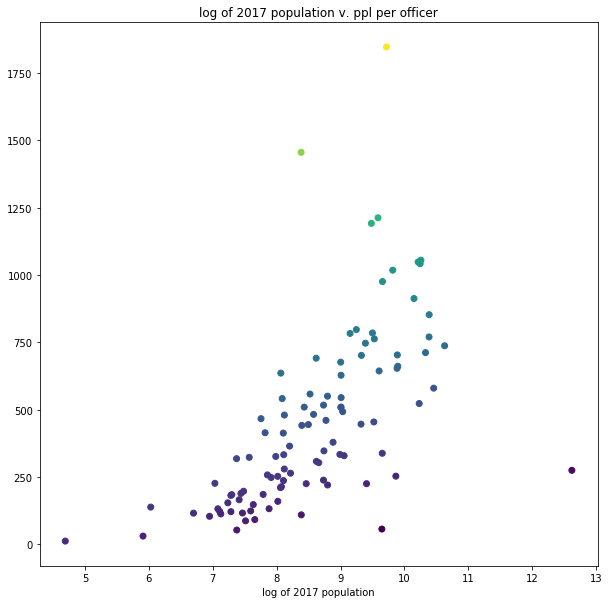

In [434]:
data = ag_pd_dissolve

fig = plt.figure(figsize=(10,10))

plt.title(s='log of 2017 population v. ppl per officer')
plt.scatter(data=data, x='log pop 2017', y='ppl per officer', c='residual')
plt.xlabel(('log of 2017 population'));

In [490]:
ag_pd_dissolve['abs residual'] = ag_pd_dissolve['residual'].map(lambda x: abs(x))

In [492]:
ag_pd_dissolve.describe()

officers       pop 2017  ppl per officer     residual  log pop 2017  \
count   102.000000     102.000000       102.000000   102.000000    102.000000   
mean     31.303922   11573.205882       449.998803   -19.200608      8.574408   
std     110.566927   30445.794355       331.260677   295.555280      1.182137   
min       3.000000     109.000000        12.111111  -471.000429      4.691348   
25%      10.000000    2429.750000       200.616667  -238.950545      7.795455   
50%      14.000000    5166.000000       355.900000   -88.137843      8.549471   
75%      23.750000   12872.750000       641.852174   119.457114      9.462345   
max    1100.000000  302407.000000      1847.000000  1315.192497     12.619529   

       abs residual  
count    102.000000  
mean     224.971686  
std      191.342275  
min        1.542698  
25%      110.623893  
50%      204.383735  
75%      278.592047  
max     1315.192497

In [494]:
ag_pd_dissolve.sort_values('abs residual', ascending=False).head(10)

agency  \
104      Scott Township P.D.   
73            Glassport P.D.   
7         Franklin Park P.D.   
77   Elizabeth Township P.D.   
23           McCandless P.D.   
36                 Plum P.D.   
33      Shaler Township P.D.   
118             Hampton P.D.   
6         Ohio Township P.D.   
111       South Fayette P.D.   

                                              geometry  officers  pop 2017  \
104  POLYGON ((-80.0774480271902 40.4153517370116, ...       9.0     16623   
73   POLYGON ((-79.8809592824277 40.3417713024548, ...       3.0      4367   
7    POLYGON ((-80.06830321776221 40.6163162161401,...      12.0     14552   
77   POLYGON ((-79.79013971441459 40.3128946051533,...      11.0     13110   
23   POLYGON ((-80.0647267615529 40.5527201201797, ...      27.0     28484   
36   POLYGON ((-79.70383740870101 40.4435251169156,...      26.0     27258   
33   POLYGON ((-79.97921322918531 40.5541728407853,...      27.0     28129   
118  POLYGON ((-79.915945441229 40.5963810108958, -...      18.0     18325   
6    POLYGON ((-80.0753413896951 40.508835024251, -...     272.0     15459   
111  POLYGON ((-80.1638828961689 40.3823619768315, ...      16.0     15614   

     ppl per officer     residual  log pop 2017  abs residual  
104      1847.000000  1315.192497      9.718543   1315.192497  
73       1455.666667   997.005208      8.381832    997.005208  
7        1212.666667   688.140264      9.585484    688.140264  
77       1191.818182   673.002079      9.481131    673.002079  
23       1054.962963   493.685226     10.257098    493.685226  
36       1048.384615   489.514351     10.213102    489.514351  
33       1041.814815   481.223358     10.244556    481.223358  
118      1018.055556   480.913914      9.816022    480.913914  
6          56.834559  -471.000429      9.645947    471.000429  
111       975.875000   447.494084      9.655923    447.494084

In [495]:
ag_pd_dissolve.sort_values('residual', ascending=False).head(10)

agency  \
104      Scott Township P.D.   
73            Glassport P.D.   
7         Franklin Park P.D.   
77   Elizabeth Township P.D.   
23           McCandless P.D.   
36                 Plum P.D.   
33      Shaler Township P.D.   
118             Hampton P.D.   
111       South Fayette P.D.   
106       Moon Township P.D.   

                                              geometry  officers  pop 2017  \
104  POLYGON ((-80.0774480271902 40.4153517370116, ...       9.0     16623   
73   POLYGON ((-79.8809592824277 40.3417713024548, ...       3.0      4367   
7    POLYGON ((-80.06830321776221 40.6163162161401,...      12.0     14552   
77   POLYGON ((-79.79013971441459 40.3128946051533,...      11.0     13110   
23   POLYGON ((-80.0647267615529 40.5527201201797, ...      27.0     28484   
36   POLYGON ((-79.70383740870101 40.4435251169156,...      26.0     27258   
33   POLYGON ((-79.97921322918531 40.5541728407853,...      27.0     28129   
118  POLYGON ((-79.915945441229 40.5963810108958, -...      18.0     18325   
111  POLYGON ((-80.1638828961689 40.3823619768315, ...      16.0     15614   
106  POLYGON ((-80.24583865863811 40.5564343781938,...      28.0     25557   

     ppl per officer     residual  log pop 2017  abs residual  
104      1847.000000  1315.192497      9.718543   1315.192497  
73       1455.666667   997.005208      8.381832    997.005208  
7        1212.666667   688.140264      9.585484    688.140264  
77       1191.818182   673.002079      9.481131    673.002079  
23       1054.962963   493.685226     10.257098    493.685226  
36       1048.384615   489.514351     10.213102    489.514351  
33       1041.814815   481.223358     10.244556    481.223358  
118      1018.055556   480.913914      9.816022    480.913914  
111       975.875000   447.494084      9.655923    447.494084  
106       912.750000   357.405721     10.148667    357.405721

In [496]:
ag_pd_dissolve.sort_values('ppl per officer', ascending=False).head(10)

agency  \
104      Scott Township P.D.   
73            Glassport P.D.   
7         Franklin Park P.D.   
77   Elizabeth Township P.D.   
23           McCandless P.D.   
36                 Plum P.D.   
33      Shaler Township P.D.   
118             Hampton P.D.   
111       South Fayette P.D.   
106       Moon Township P.D.   

                                              geometry  officers  pop 2017  \
104  POLYGON ((-80.0774480271902 40.4153517370116, ...       9.0     16623   
73   POLYGON ((-79.8809592824277 40.3417713024548, ...       3.0      4367   
7    POLYGON ((-80.06830321776221 40.6163162161401,...      12.0     14552   
77   POLYGON ((-79.79013971441459 40.3128946051533,...      11.0     13110   
23   POLYGON ((-80.0647267615529 40.5527201201797, ...      27.0     28484   
36   POLYGON ((-79.70383740870101 40.4435251169156,...      26.0     27258   
33   POLYGON ((-79.97921322918531 40.5541728407853,...      27.0     28129   
118  POLYGON ((-79.915945441229 40.5963810108958, -...      18.0     18325   
111  POLYGON ((-80.1638828961689 40.3823619768315, ...      16.0     15614   
106  POLYGON ((-80.24583865863811 40.5564343781938,...      28.0     25557   

     ppl per officer     residual  log pop 2017  abs residual  
104      1847.000000  1315.192497      9.718543   1315.192497  
73       1455.666667   997.005208      8.381832    997.005208  
7        1212.666667   688.140264      9.585484    688.140264  
77       1191.818182   673.002079      9.481131    673.002079  
23       1054.962963   493.685226     10.257098    493.685226  
36       1048.384615   489.514351     10.213102    489.514351  
33       1041.814815   481.223358     10.244556    481.223358  
118      1018.055556   480.913914      9.816022    480.913914  
111       975.875000   447.494084      9.655923    447.494084  
106       912.750000   357.405721     10.148667    357.405721

In [497]:
ag_pd_dissolve[ag_pd_dissolve['agency'].str.contains('Pittsburgh')]

agency                                           geometry  \
63   East Pittsburgh P.D.  POLYGON ((-79.8336939635457 40.4005454952576, ...   
128       Pittsburgh P.D.  POLYGON ((-79.9072100559346 40.3615741498475, ...   

     officers  pop 2017  ppl per officer    residual  log pop 2017  \
63        9.0      1775       197.222222 -212.175322      7.481556   
128    1100.0    302407       274.915455 -415.636674     12.619529   

     abs residual  
63     212.175322  
128    415.636674